In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
#%matplotlib notebook
%reload_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = 10, 5
np.set_printoptions(precision=5, suppress=True)

# Toy example

(30, 5) (2, 30)


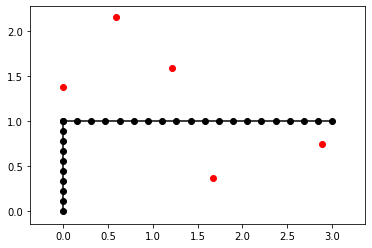

In [2]:
from trajectory import Trajectory

np.random.seed(1)
t1 = Trajectory(dim=2, n_complexity=2, model='polynomial', 
                coeffs=np.array([[0., 0.], [0., 1.]]))
t2 = Trajectory(dim=2, n_complexity=2, model='polynomial', 
                coeffs=np.array([[-3., 3.], [1., 0.]]))
times1 = np.linspace(0, 1, 10)
times2 = np.linspace(1, 2, 20)
anchors = 4 * np.random.rand(2, 5)
fig, ax = plt.subplots()
ax.scatter(*anchors, color='red')
t1.plot(times=times1, ax=ax, color='black')
t2.plot(times=times2, ax=ax, color='black')
ax.axis('equal')

from measurements import get_measurements

b1, D1 = get_measurements(t1, anchors, seed=1, times=times1)
b2, D2 = get_measurements(t2, anchors, seed=1, times=times2)
F = np.hstack((b1, b2))
D = np.vstack((D1, D2))
times = np.r_[times1, times2]
print(D.shape, F.shape)

#plt.matshow(D)

In [3]:
## Convert toy example to something more realistic. 
df = pd.DataFrame(columns=['timestamp', 'anchor_id', 'distance'])
i = 0

anchor_ids = range(anchors.shape[1])
print(anchor_ids)

noise = 1e-3
np.random.seed(1)

for d_mn_row, time in zip(D, times):
    anchor_indexes = np.where(d_mn_row>0)[0]
    for anchor_idx in anchor_indexes:
        distance=d_mn_row[anchor_idx]
        if noise > 0:
            distance += np.random.normal(scale=noise)
        df.loc[i, :] = dict(
            timestamp=time,
            anchor_id=anchor_ids[anchor_idx],
            distance=distance
        )
        i += 1
df.head()

range(0, 5)


,timestamp,anchor_id,distance
0,0,0,2.92056
1,0,1,8.85635
2,0,2,1.91007
3,0,3,3.9802
4,0,4,4.99064


# Averaging Algorithm

Estimate the trajectory recursively over a fixed  time window.

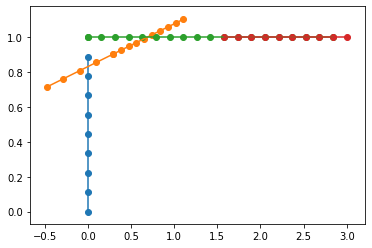

In [4]:
from iterative_algorithms import averaging_algorithm
C_list, t_list = averaging_algorithm(D, anchors, F, times, t_window=1.0)

np.testing.assert_allclose(C_list[0], t1.coeffs)
np.testing.assert_allclose(C_list[-2], t2.coeffs)
np.testing.assert_allclose(C_list[-1], t2.coeffs)

fig, ax = plt.subplots()
for C, t in zip(C_list, t_list):
    trajk = t1.copy()
    trajk.set_coeffs(coeffs=C)
    trajk.plot(ax=ax, times=t)

# Build-up Algorithm


Refine the current trajectory as long as the new measurements "fit the model" well enough. 

Create a completely new trajectory model with measurements if they stop fitting. 

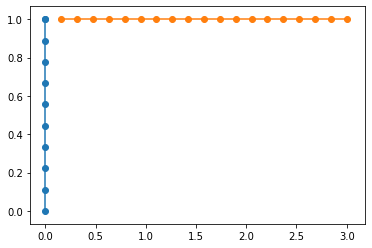

In [5]:
from iterative_algorithms import build_up_algorithm

C_list, t_list = build_up_algorithm(D, anchors, F, times, eps=1e-3)


np.testing.assert_allclose(C_list[0], t1.coeffs)
np.testing.assert_allclose(C_list[1], t2.coeffs)


fig, ax = plt.subplots()
for C, t in zip(C_list, t_list):
    trajk = t1.copy()
    trajk.set_coeffs(coeffs=C)
    trajk.plot(ax=ax, times=t)